In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datatable as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# load and compress the data

In [ ]:
%%time
example_sample_submission = dt.fread("/kaggle/input/jane-street-market-prediction/example_sample_submission.csv")
features = dt.fread("/kaggle/input/jane-street-market-prediction/features.csv")
example_test = dt.fread("/kaggle/input/jane-street-market-prediction/example_test.csv")
train = dt.fread("/kaggle/input/jane-street-market-prediction/train.csv")

In [ ]:
example_sample_submission = example_sample_submission.to_pandas()
features = features.to_pandas()
example_test = example_test.to_pandas()
train = train.to_pandas()

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage. Credits to Guillaume Martin  
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
%%time

for name, ds in zip(["submission","features","train","test"],[example_sample_submission, features, train, example_test]):
    print("{} \n".format(name))
    ds = reduce_mem_usage(ds)
    print("\n")

# General information about the data

In [ ]:
for name, ds in zip(["submission","features","train","test"],[example_sample_submission, features, train, example_test]):
    print("dataset {} \n".format(name))
    print("{}".format(ds.info()))
    print("\n")

In [ ]:
#missing values
for name, ds in zip(["submission","features","train","test"],[example_sample_submission, features, train, example_test]):
    print("dataset {} \n".format(name))
    print("{} \n".format(ds.isnull().sum().sort_values(ascending=False)))
    print("\n")

In [ ]:
pd.concat([train.head(), train.tail()],axis=0)

* in general the goal of the competition is to build a model to maximize the utility score based on historical, anonymized stock exchange data
* the data at hand contains for each day a number of trading opportunities and the model should choose the relevant trades to finally maximize the utility function 
* in really simplified terms, the following graphic resumes the problem:
    * we ask the model a given day which trades to do
    * the model evaluates if the given trade should be done (if it's adding up utility for the trader) or not
    
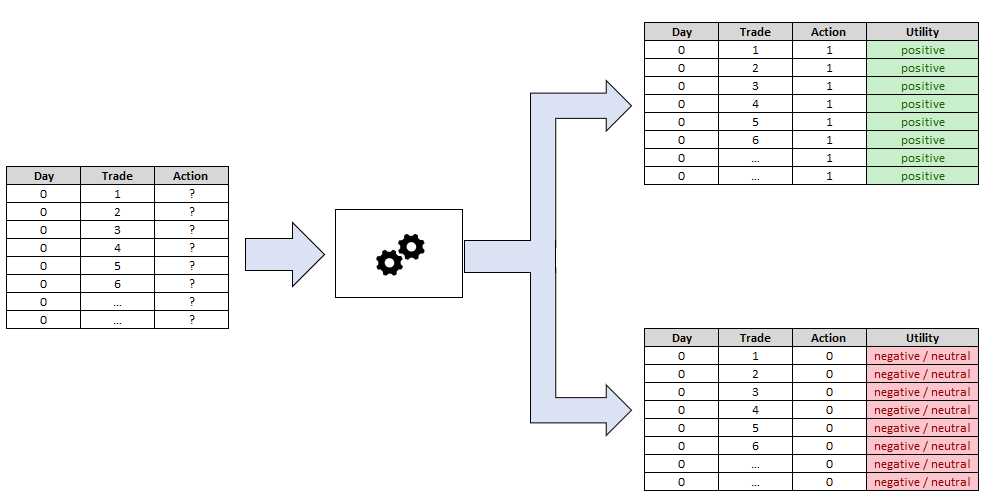

# How to decide whether to take or not to take an opportunity?

In the evaluation metric utilization score, there is a attribute "action" which indicates whether the opportunity should be taken (action = 1) or not (action = 0)

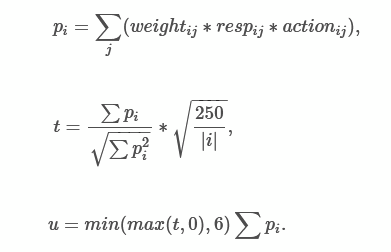

In the data sets, there isn't a dichotomous attribute called 'action'. 
So we have to derive the attribute and train the classification model on the generated attribute 'action' or we train the model on the attribute(s) used to derive action

but it's useful to understand first of all the utility score function:

in essence the most important part to find out which feature is best to derive the feature 'action' is the calculation of p:

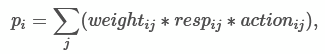

In [ ]:
def calc_p(date, weight,resp,action):
    p = np.sum(np.bincount(date,weight * resp * action))
    return p

In [ ]:
example = train[train["date"]==0]
example.head()

if we say that all of the opportunities seem useful to us ( $ \forall $ action = 1) we got the following:

In [ ]:
calc_p(example["date"],example["weight"],example["resp"], np.ones(example.shape[0]))

if we say that none of the opportunities seem useful to us ( $ \forall $ action = 0) we got the following:

In [ ]:
calc_p(example["date"],example["weight"],example["resp"], np.zeros(example.shape[0]))

but why is a trade useful for us? 
without considering more complex decision factors, logically we would say that it is avantageous if a trades creates positive return (green) and the trade shouldn't be executed if its return is negative (red):

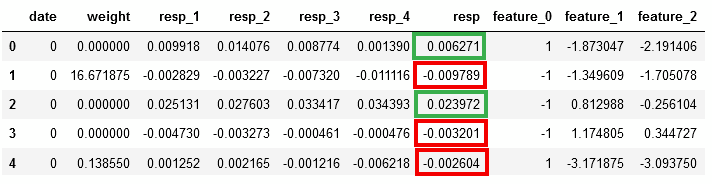

The maximum p for the day 0 is therefore:

In [ ]:
a = (example["resp"]>0).astype("int")

calc_p(example["date"],example["weight"],example["resp"],a)

and the utility  score:

In [ ]:
def utility_score(date, weight, resp, action, print_Pi=False):
    Pi = np.bincount(date, weight * resp * action)
    if print_Pi:
        print(Pi)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

In [ ]:
a = (example["resp"]>0).astype("int")

utility_score(example["date"],example["weight"],example["resp"],a,print_Pi=True)

The maximum utility score would (over all days) hence be:

In [ ]:
a = (train["resp"]>0).astype("int")

utility_score(train["date"],train["weight"],train["resp"],a)

Having clarified that, it seems obvious that the feature 'action' can be derived from the feature 'resp' (the return).
So, we can choose if we want to build a regression model on the feature 'resp' or to build a model for classification on the derived feature 'action'

First Look at the Features:

In [ ]:
fig, sub = plt.subplots(int((130/5)),5,figsize=(20,40))

for feat,sp in zip(train.columns[train.columns.str.contains("feature")],sub.flatten()):
    
    sns.distplot(train[feat].sample(5*10**5), hist_kws={"edgecolor":"black"}, ax=sp)
    sp.grid();
fig.tight_layout()

* There are some features (e.g. feat 60 - 63) seeming to have the same distribution
* some of them have a positive kurtosis
* some of them are skewed
* having a look at the pearson corr matrix could be beneficial to backup this hypothesis

In [ ]:
fig, sub = plt.subplots(1,1,figsize=(35,30))

corr_matrix = train[train.columns[train.columns.str.contains("feature")]].corr()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask,lw=0.09, cmap=cmap, linecolor="grey", ax= sub)

In [ ]:
corr_flatten = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_flatten = corr_flatten.drop_duplicates().reset_index().rename(columns={"level_0":"first","level_1":"second",0:"corr"})
corr_flatten = corr_flatten.drop(corr_flatten.index[[0]]).reset_index(drop=True).sort_values(by="corr",ascending=False)

In [ ]:
corr_flatten[corr_flatten["corr"]>0.95]

* the suspicion that there are some features being highly correlated seems to be justified 
* maybe it's possible to consolidate the information included in the original features in a reduced number of features (Principal Component Analysis)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca_components = pca.fit_transform(train[train.columns[train.columns.str.contains("feature")]].dropna())

In [ ]:
fig,sub = plt.subplots(1,2,figsize=(22,6))
sns.lineplot(x=range(0,50),y=np.cumsum(pca.explained_variance_ratio_[:50]),ax=sub[0])
sns.lineplot(x=range(0,50),y=pca.explained_variance_[:50],ax=sub[1])
sub[0].set_xticks(range(0,50))
sub[1].set_xticks(range(0,50))

sub[0].set_ylabel("cum. variance explained by principal comp.")
sub[1].set_ylabel("variance explained by principal comp.")

sub[0].set_xlabel("number of principal comp.")
sub[1].set_xlabel("principal comp.")

sub[0].grid()
sub[1].grid()

fig.tight_layout()

* through simple linear combination it is possible to express the information included in the 130 features in 20-50 features
* thus a reduction of features of more than ~61 % is possible to keep the model simpler

Let's have a deeper look into the anonymized attributes containing the string "feature" provided by the competition:

In [ ]:
train_col_ls = train.columns[train.columns.str.contains("feature")].to_list()
train_col_ls.extend(["date"])

In [ ]:
feature_df = train[train_col_ls].groupby("date").mean()

for performance reasons let's have a look at the first 10 features to grasp an understanding of the data:

In [ ]:
colors = ['#8ECAE6','#219EBC','#023047','#023047','#023047','#0E402D','#023047','#023047','#F77F00','#D62828']

plt.figure(figsize=(20,20))
for i in range(0,10):
    plt.subplot(10,1,i+1)
    ax = sns.lineplot(x=feature_df.index,y=feature_df[f'feature_{i}'],color=colors[i],lw=1)
    ax.grid()
plt.show()

In [ ]:
fig, sub = plt.subplots(1,1,figsize=(16,8))
colors = ['#219EBC','#023047','#023047','#023047','#0E402D']
counter = 0

for feat in train.columns[2:7]:
    df = train[feat]
    sub.plot(np.cumsum(df))
    counter+=1
sub.grid()

To be continued...